In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=4

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1250 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [6]:
len(dataset)

40

In [7]:
38*32

1216

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[2 3 3 4 1 5 1 2 3 0 0 4 2 5 3 3 1 1 5 3 2 3 5 1 3 2 4 3 4 3 1 2]


In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  ...
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]]

 [[ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  ...
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]]

 [[ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  [ 77.       181.       205.      ]
  ...
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]
  [ 65.       154.       181.      ]]

 ...

 [[122.5      219.       234.5     ]
  [122.5      219.       234.5     ]
  [122.5      219.       234.5     ]
  ...
  [ 78.899994 183.9      206.9     ]
  [ 78.       183.       206.      ]
  [ 78.       183.       206.      ]]

 [[123.       219.       235.      ]
  [123.       219.       235.      ]


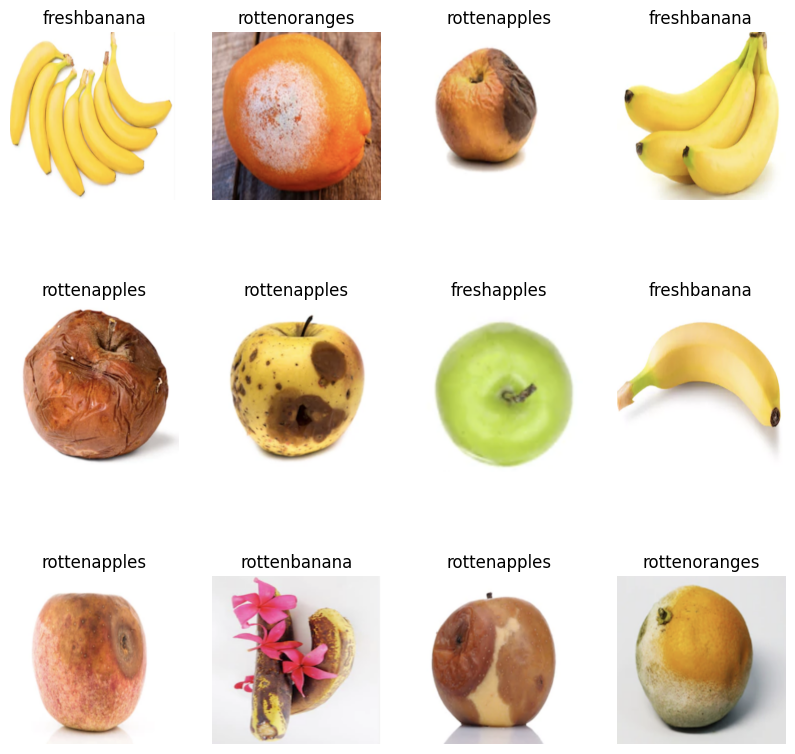

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

32
4
4


In [14]:
#shuffle
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
#building the build
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
#data_augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
#applying data aut on training data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 149, 149, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

In [20]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
32/32 [==============================] - 192s 5s/step - loss: 1.7142 - accuracy: 0.2746 - val_loss: 1.3311 - val_accuracy: 0.4297
Epoch 2/3
32/32 [==============================] - 166s 5s/step - loss: 1.3710 - accuracy: 0.4205 - val_loss: 1.2312 - val_accuracy: 0.5312
Epoch 3/3
32/32 [==============================] - 151s 5s/step - loss: 1.1318 - accuracy: 0.5473 - val_loss: 0.9511 - val_accuracy: 0.5547


In [24]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 11s 1s/step - loss: 0.4406 - accuracy: 0.8516


In [25]:
scores

[0.4406360983848572, 0.8515625]

In [26]:
#plotting accuracy n loss curves
history

In [27]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 32}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

8

In [31]:
history.history['loss'][:5]

[0.9741986989974976,
 0.9698500037193298,
 0.8207844495773315,
 0.7920011878013611,
 0.630649983882904]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [1]:
EPOCHS = 8
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'plt' is not defined

# run prediction on a sample image

first image to predict
actual label: rottenoranges
1/1 [==============================] - 1s 1s/step
predicted label: rottenoranges


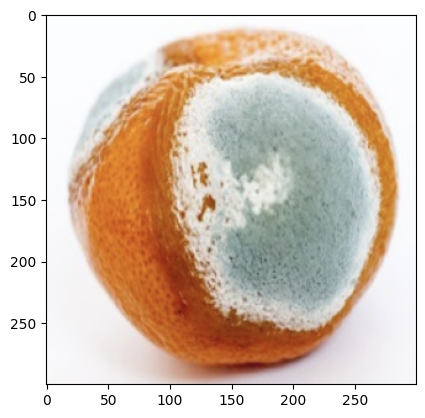

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
#function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 157ms/step


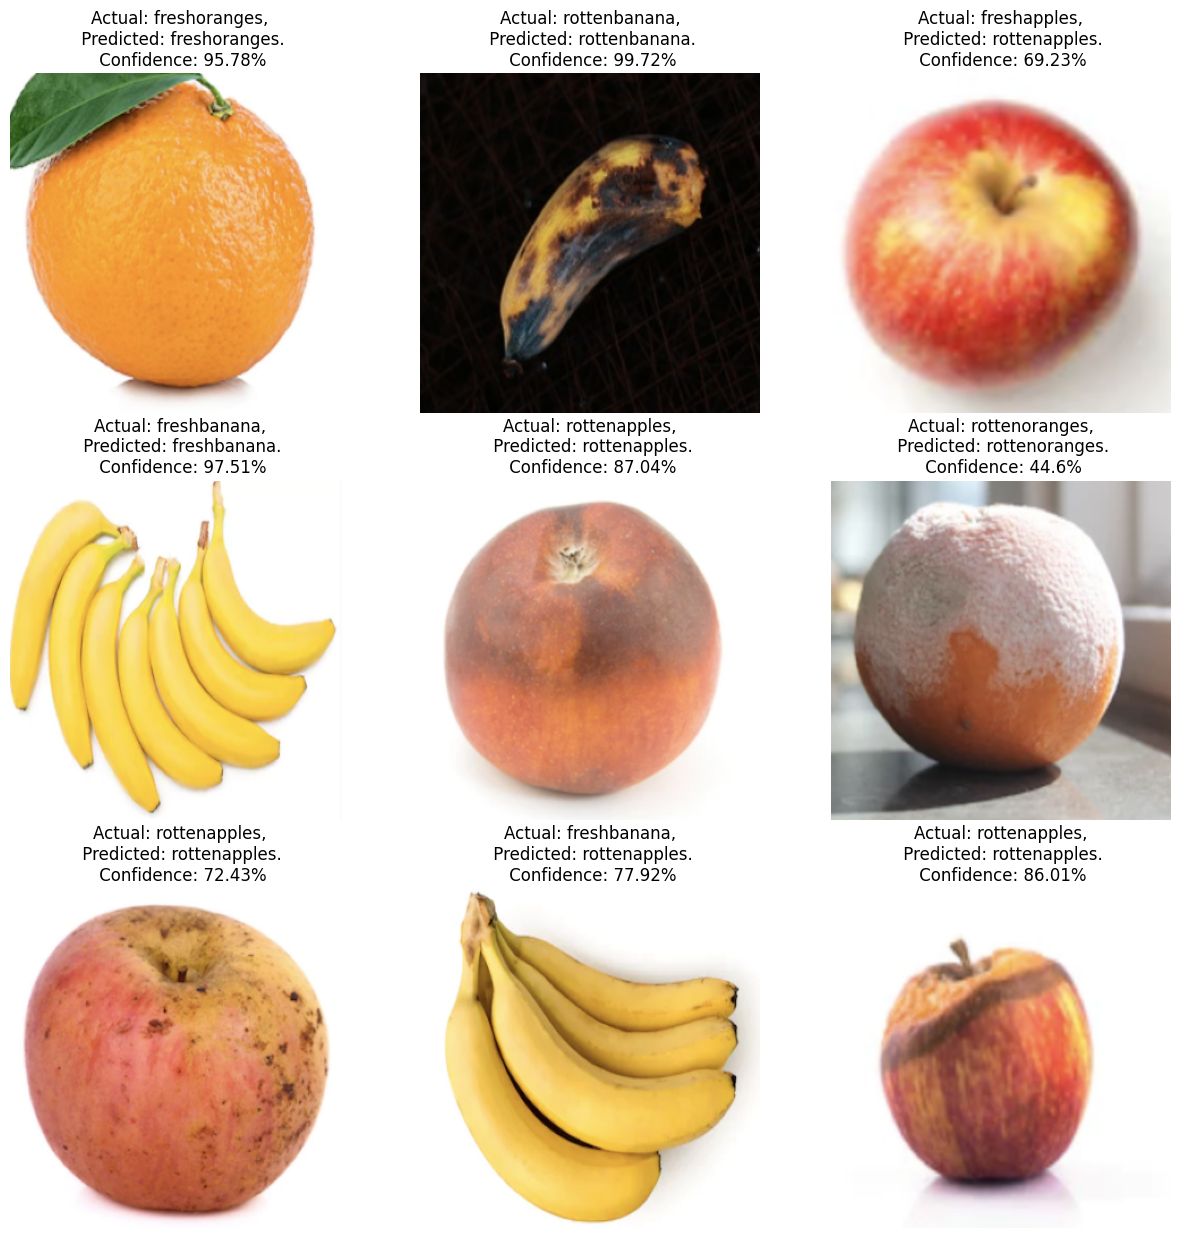

In [46]:
#run inference on few samples images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
#saving the models
#we append the model to the listd of models as a new version

import os
# print(os.listdir("models"))
model_version=max([int(i) for i in os.listdir("models") + [0]]) +1
model.save(f"models/{model_version}")

ValueError: invalid literal for int() with base 10: 'fruits.h5'

In [48]:
model.save("models/fruits.h5")

C:\Users\Personal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
